## 🐇🦊 Lotka–Volterra Model (Predator–Prey)

The classic LV model describes the interaction between two populations:
- \(x(t)\): prey,
- \(y(t)\): predators.

The ordinary differenta¡ial equations(ODEs) are:

\begin{aligned}
\frac{dx}{dt} &= \alpha x - \beta x y, \\
\frac{dy}{dt} &= \delta x y - \gamma y,
\end{aligned}

donde:
- $(\alpha > 0)$: natural prey growth rate,  
- $(\beta > 0)$: depredation rate (prey–predator encounters),  
- $(\delta > 0)$: prey to predator conversion efficiency,  
- $(\gamma > 0)$: natural predator mortality rate.

---

### 🔹 Vectorial form
$$
\dot{\mathbf{z}} =
\begin{bmatrix}
\dot{x} \\
\dot{y}
\end{bmatrix}
=
\begin{bmatrix}
\alpha x - \beta x y \\
\delta x y - \gamma y
\end{bmatrix}.
$$
---

### 🔹 Equilibrum points

- $(x^\*, y^\*) = (0,0)$  
- $(x^\*, y^\*) = \left(\tfrac{\gamma}{\delta},\; \tfrac{\alpha}{\beta}\right)$  

---

### 🔹 Variant with load capacity (optional)

If we introduce a **load capacity** $(K)$ for the prey, the equations follow:

$$
\frac{dx}{dt} = \alpha x \left(1 - \frac{x}{K}\right) - \beta x y, 
\qquad
\frac{dy}{dt} = \delta x y - \gamma y.
$$

---

### 🔹 Example parameter values

$$
\alpha = 1.1, \quad 
\beta = 0.4, \quad 
\delta = 0.1, \quad 
\gamma = 0.4
$$

### 🔹 Numeric exploration

- Elige $\alpha$ o $\beta$ como parámetro a variar.
  - Sweep $\alpha$ between 0.5 y 3.0 → we will see how "environment fertility" evolves.
  - Sweep $\beta$ between 0.05 y 2.0 → we will see how depredation efficiency affects.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import random as rd

# -------- Model Lotka-Volterra --------
def lotka_volterra_deq(t, x, y, alpha, beta, delta, gamma):
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return dxdt, dydt

# -------- Integrador RK4 --------
def rk4_step(t, x, y, h, alpha, beta, delta, gamma):
    k1x, k1y = lotka_volterra_deq(t, x, y, alpha, beta, delta, gamma)
    k2x, k2y = lotka_volterra_deq(t + h/2, x + h*k1x/2, y + h*k1y/2, alpha, beta, delta, gamma)
    k3x, k3y = lotka_volterra_deq(t + h/2, x + h*k2x/2, y + h*k2y/2, alpha, beta, delta, gamma)
    k4x, k4y = lotka_volterra_deq(t + h, x + h*k3x, y + h*k3y, alpha, beta, delta, gamma)

    x_next = x + (h/6)*(k1x + 2*k2x + 2*k3x + k4x)
    y_next = y + (h/6)*(k1y + 2*k2y + 2*k3y + k4y)
    return x_next, y_next

def simulate(alpha, beta, delta, gamma, x0, y0, t_max=300, h=0.02):
    steps = int(t_max / h)
    t = 0
    x, y = x0, y0
    xs, ys, ts = [], [], []
    for _ in range(steps):
        xs.append(x)
        ys.append(y)
        ts.append(t)
        x, y = rk4_step(t, x, y, h, alpha, beta, delta, gamma)
        t += h
    return np.array(ts), np.array(xs), np.array(ys)

# -------- Metrics --------
def metrics_from_timeseries(t, x, discard_frac=0.3):
    idx0 = int(len(t) * discard_frac)  # discard transitory state
    t = t[idx0:]
    x = x[idx0:]

    peaks, _ = find_peaks(x, distance=20)
    peaks_inv, _ = find_peaks(-x, distance=20)
    if len(peaks) > 1:
        amp = np.mean(x[peaks]) - np.mean(x[peaks_inv])
        periods = np.diff(t[peaks])
        period = np.mean(periods)
        mean_x = np.mean(x[peaks[0]:peaks[-1]])
        var_x = np.var(x[peaks[0]:peaks[-1]])
        maxima = x[peaks[-10:]]
    else:
        amp, period, maxima, mean_x, var_x = 0, np.nan, [], np.nan, np.nan
    
    return mean_x, var_x, amp, period, maxima

# -------- Barrido betas --------
def sweep_betas(betas, alpha, delta, gamma, x0, y0):
    mean_list, var_list, amp_list, period_list, bifurcation_data = [], [], [], [], []
    for beta in betas:
        t, x, y = simulate(alpha, beta, delta, gamma, x0, y0)
        mean_x, var_x, amp, period, maxima = metrics_from_timeseries(t, x)
        mean_list.append(mean_x)
        var_list.append(var_x)
        amp_list.append(amp)
        period_list.append(period)
        bifurcation_data.append(maxima)
    
    return np.array(mean_list), np.array(var_list), np.array(amp_list), np.array(period_list), bifurcation_data

# -------- Barrido alfas --------
def sweep_alphas(beta, alphas, delta, gamma, x0, y0):
    mean_list, var_list, amp_list, period_list, bifurcation_data = [], [], [], [], []
    for alpha in alphas:
        t, x, y = simulate(alpha, beta, delta, gamma, x0, y0)
        mean_x, var_x, amp, period, maxima = metrics_from_timeseries(t, x)
        mean_list.append(mean_x)
        var_list.append(var_x)
        amp_list.append(amp)
        period_list.append(period)
        bifurcation_data.append(maxima)
    
    return np.array(mean_list), np.array(var_list), np.array(amp_list), np.array(period_list), bifurcation_data

It is ploted the 2 spices population vs time over the following equations:

\begin{aligned}
\frac{dx}{dt} &= \alpha x - \beta x y, \\
\frac{dy}{dt} &= \delta x y - \gamma y,
\end{aligned}

We performed a numerical simlation with a Runge-Kutta 4 method using the example parameters to observe that, after a certain period of time, the memory of the initial conditions is lost, allowing us to begin formulating hypotheses.
The initial conditions (populations) are:

\begin{aligned}
x_0 &= 10, \\
y_0 &= 5
\end{aligned}

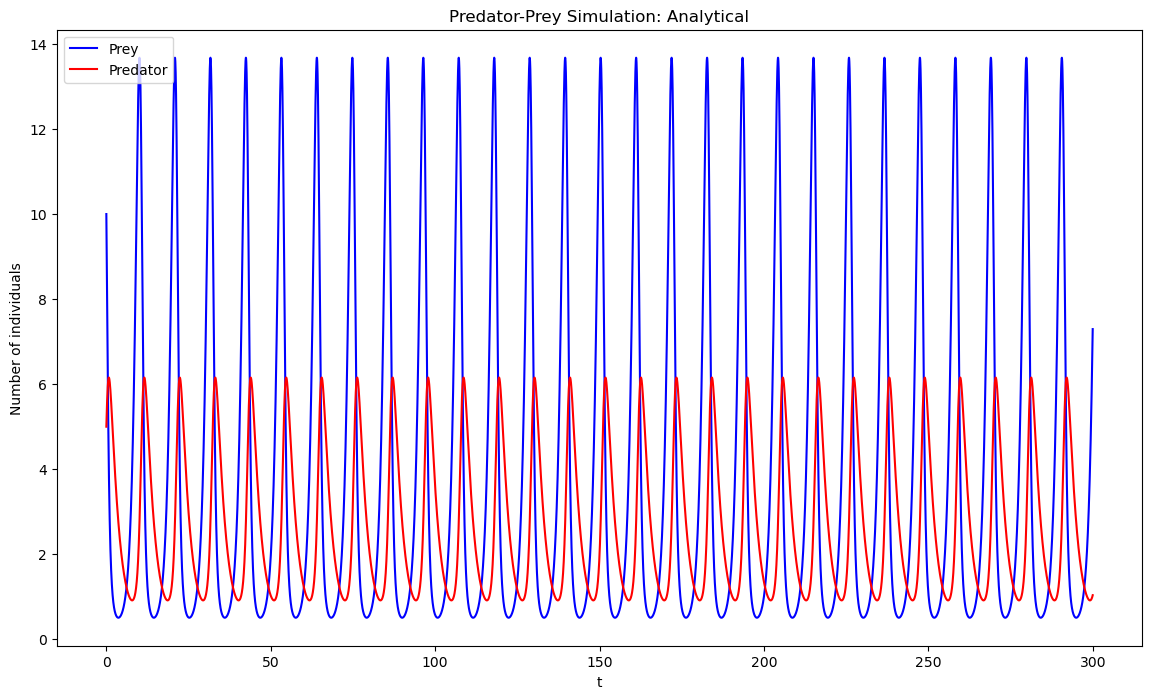

In [ ]:
# Model parameters values
alpha, beta, delta, gamma = 1.1, 0.4, 0.1, 0.4

# Initial conditions
x0, y0 = 10, 5

t, x, y = simulate(alpha, beta, delta, gamma, x0, y0)
m, v, A, p, maxima = metrics_from_timeseries(t, x)

# Gráfica
plt.figure(figsize=(14, 8))
plt.plot(t, x, 'b-', label='Prey')
plt.plot(t, y, 'r-', label='Predator')

plt.xlabel("t")
plt.ylabel("Number of individuals")
plt.legend()
plt.title("Predator-Prey Simulation: Analytical")

plt.show()

Now we sweep the $\beta$ and $\alpha$ parameter to see how affect the selected parameters.

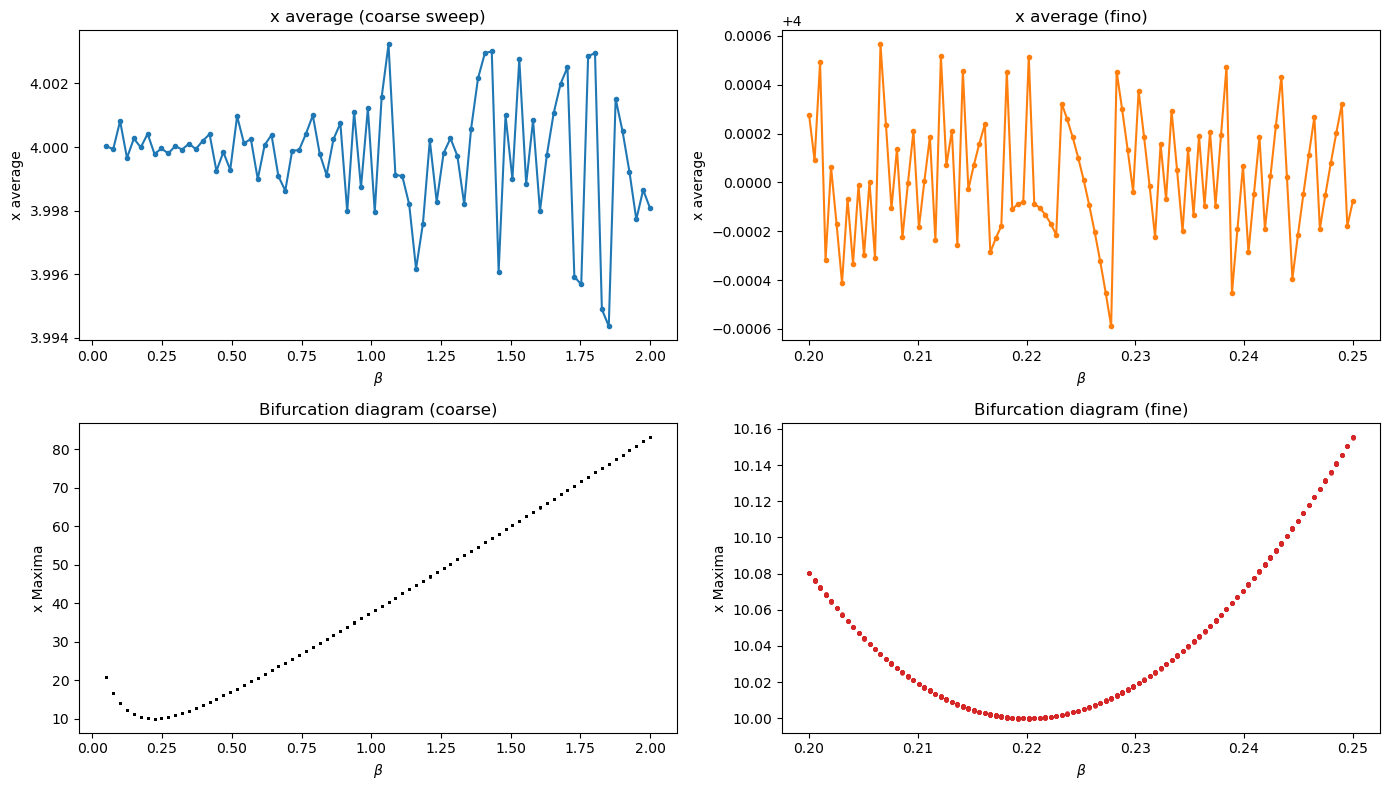

In [ ]:
#Variamos beta
# -------- Base parameters --------
alpha, delta, gamma = 1.1, 0.1, 0.4
x0, y0 = 10, 5
#x0, y0 = gamma/delta + 0.1, alpha/beta + 0.1

# Sweep coarse
betas_coarse = np.linspace(0.05, 2.0, 80)
mean_c, var_c, amp_c, period_c, bif_c = sweep_betas(betas_coarse, alpha, delta, gamma, x0, y0)


# Fine sweep in subwindow [0.25, 0.6]
betas_fine = np.linspace(0.20, 0.25, 100)
mean_f, var_f, amp_f, period_f, bif_f = sweep_betas(betas_fine, alpha, delta, gamma, x0, y0)

# -------- Plots --------
plt.figure(figsize=(14,8))

plt.subplot(2,2,1)
plt.plot(betas_coarse, mean_c, '-o', ms=3)
plt.xlabel(r'$\beta$')
plt.ylabel('x average')
plt.title('x average (coarse sweep)')

plt.subplot(2,2,2)
plt.plot(betas_fine, mean_f, '-o', ms=3, color='tab:orange')
plt.xlabel(r'$\beta$')
plt.ylabel('x average')
plt.title('x average (fino)')

plt.subplot(2,2,3)
for i, maxima in enumerate(bif_c):
    plt.scatter([betas_coarse[i]]*len(maxima), maxima, color='k', s=1)
plt.xlabel(r'$\beta$')
plt.ylabel('x Maxima')
plt.title('Bifurcation diagram (coarse)')

plt.subplot(2,2,4)
for i, maxima in enumerate(bif_f):
    plt.scatter([betas_fine[i]]*len(maxima), maxima, color='tab:red', s=5)
plt.xlabel(r'$\beta$')
plt.ylabel('x Maxima')
plt.title('Bifurcation diagram (fine)')

plt.tight_layout()
plt.show()

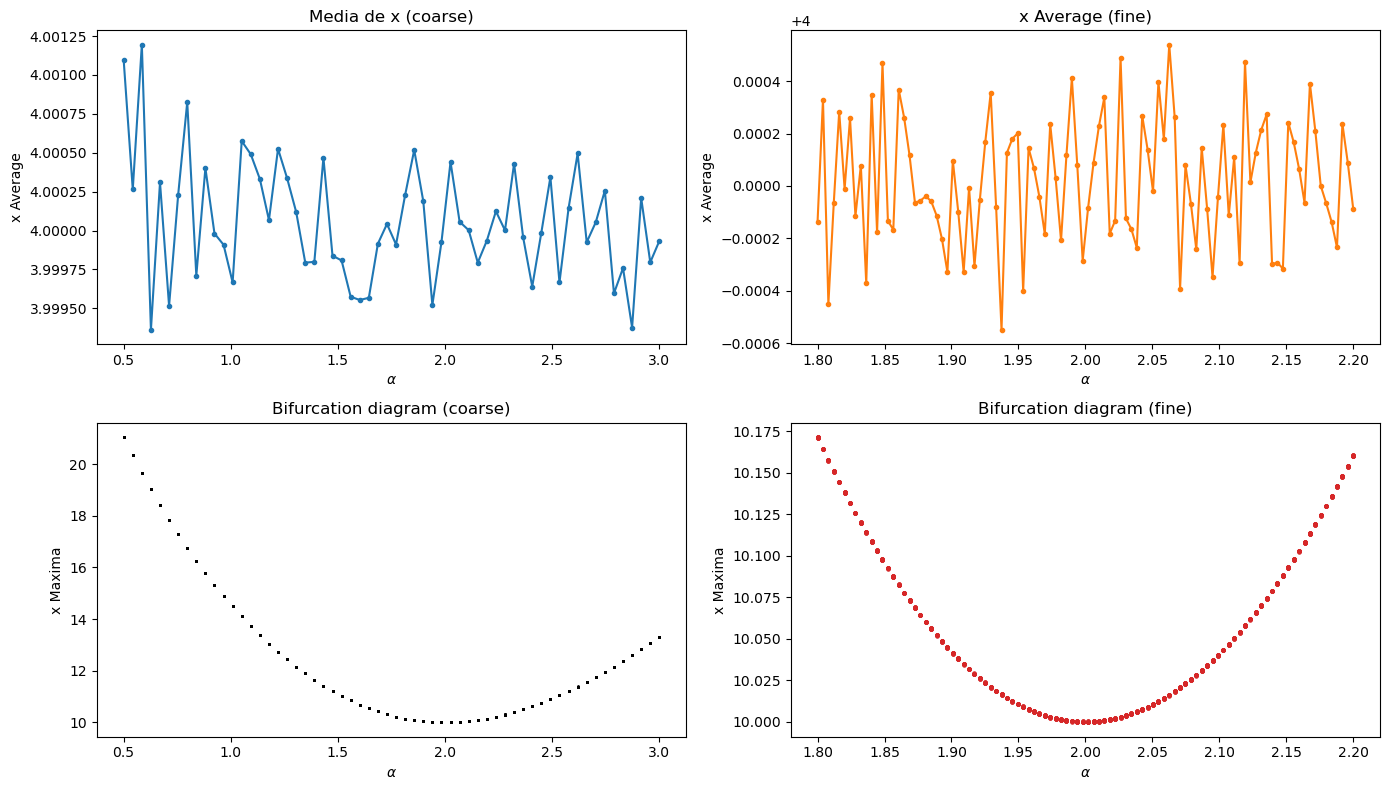

In [ ]:
#Variamos alpha
# -------- Base parameters --------
beta, delta, gamma = 0.4, 0.1, 0.4
x0, y0 = 10, 5
#x0, y0 = gamma/delta + 0.1, alpha/beta + 0.1

# Sweep coarse
alphas_coarse = np.linspace(0.5, 3., 60)
mean_c, var_c, amp_c, period_c, bif_c = sweep_alphas(beta, alphas_coarse, delta, gamma, x0, y0)

# Fine sweep in subwindow  [1.8, 2.2]
alphas_fine = np.linspace(1.8, 2.2, 100)
mean_f, var_f, amp_f, period_f, bif_f = sweep_alphas(beta, alphas_fine, delta, gamma, x0, y0)

# -------- Plots --------
plt.figure(figsize=(14,8))

plt.subplot(2,2,1)
plt.plot(alphas_coarse, mean_c, '-o', ms=3)
plt.xlabel(r'$\alpha$')
plt.ylabel('x Average')
plt.title('Media de x (coarse)')

plt.subplot(2,2,2)
plt.plot(alphas_fine, mean_f, '-o', ms=3, color='tab:orange')
plt.xlabel(r'$\alpha$')
plt.ylabel('x Average')
plt.title('x Average (fine)')

plt.subplot(2,2,3)
for i, maxima in enumerate(bif_c):
    plt.scatter([alphas_coarse[i]]*len(maxima), maxima, color='k', s=1)
plt.xlabel(r'$\alpha$')
plt.ylabel('x Maxima')
plt.title('Bifurcation diagram (coarse)')

plt.subplot(2,2,4)
for i, maxima in enumerate(bif_f):
    plt.scatter([alphas_fine[i]]*len(maxima), maxima, color='tab:red', s=5)
plt.xlabel(r'$\alpha$')
plt.ylabel('x Maxima')
plt.title('Bifurcation diagram (fine)')

plt.tight_layout()
plt.show()

We ploted the x mean for each $\beta$ and $\alpha$ respective step. On the other hand, it's ploted the absolute value of the last peaks value for x. the overlap so we can see there is just one maximum for each $\alpha$, $\beta$ configuration.
The average population for prey it is almost constant around 4 for this initial conditions, but we can see in the $\beta$ bifurcation diagram that exists a minimum around the $\beta = 0.22$ and knowing the value of $\alpha = 1.1$, besides in the $\alpha$ graphics we find that the minumum is in 2. We compute $\frac{\alpha}{\beta} = 5$ for both cases because is the $x_0$ component of the equilibrum point. This number is our initial condition, so we found a minimum of activity just reaching the x component of the equilibrum. 

We are about to plot the both sweeps.

In [ ]:
# Definir los rangos de alpha y beta
beta_vals = np.linspace(0.05, 2.0, 80)
alpha_vals = np.linspace(0.5, 4.0, 80)

# Crear arrays vacíos para guardar resultados
mean_x = np.zeros((len(alpha_vals), len(beta_vals)))
var_x = np.zeros_like(mean_x)
amp = np.zeros_like(mean_x)
period = np.zeros_like(mean_x)

# Bucle doble sobre la grilla
for i, a in enumerate(alpha_vals):
    for j, b in enumerate(beta_vals):
        t, x, y = simulate(a, b, delta, gamma, x0, y0)
        m, v, A, p, maxima = metrics_from_timeseries(t, x)
        mean_x[i, j], var_x[i, j], amp[i, j], period[i, j] = m, v, A, p

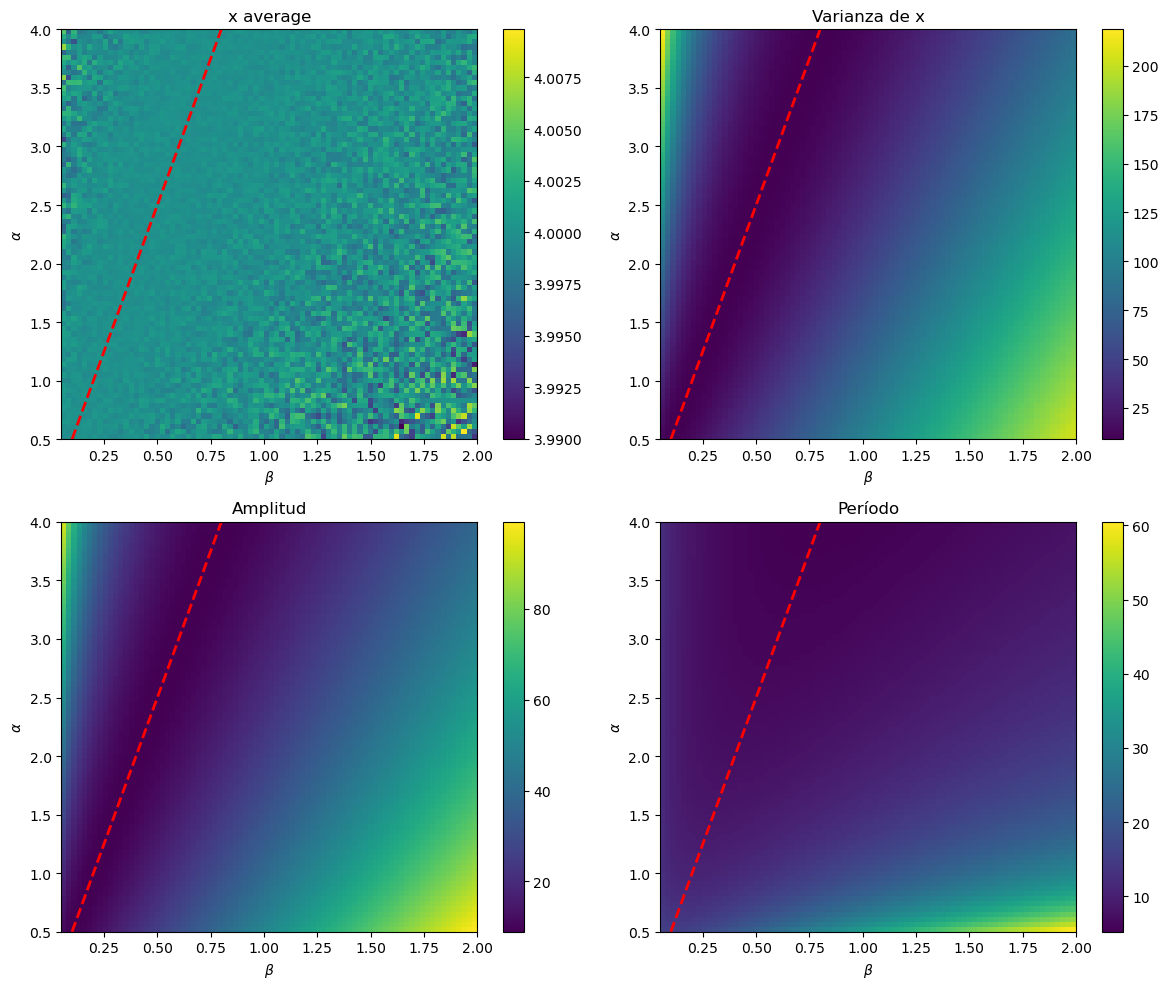

In [ ]:
# --------- Graficar resultados ---------

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
# We compute the predator equilibrum
alpha_line = np.linspace(alpha_vals.min(), alpha_vals.max(), 200)
# Relación alpha = 5 * beta
beta_line = alpha_line / 5

# Media
im1 = axs[0, 0].imshow(mean_x, extent=[beta_vals.min(), beta_vals.max(), 
                                        alpha_vals.min(), alpha_vals.max()],
                       origin="lower", aspect="auto")

# Dibujar línea sobre el heatmap
axs[0, 0].plot(beta_line, alpha_line, color="red", linestyle="--", linewidth=2, label=r"$\alpha/\beta=5$")
axs[0, 0].set_title("x average")
axs[0, 0].set_xlabel(r"$\beta$")
axs[0, 0].set_ylabel(r"$\alpha$")
plt.colorbar(im1, ax=axs[0, 0])

# Varianza
im2 = axs[0, 1].imshow(var_x, extent=[beta_vals.min(), beta_vals.max(), 
                                        alpha_vals.min(), alpha_vals.max()],
                       origin="lower", aspect="auto")

# Dibujar línea sobre el heatmap
axs[0, 1].plot(beta_line, alpha_line, color="red", linestyle="--", linewidth=2, label=r"$\alpha/\beta=5$")
axs[0, 1].set_title("Varianza de x")
axs[0, 1].set_xlabel(r"$\beta$")
axs[0, 1].set_ylabel(r"$\alpha$")
plt.colorbar(im2, ax=axs[0, 1])

# Amplitud
im3 = axs[1, 0].imshow(amp, extent=[beta_vals.min(), beta_vals.max(), 
                                     alpha_vals.min(), alpha_vals.max()],
                       origin="lower", aspect="auto")
axs[1, 0].plot(beta_line, alpha_line, color="red", linestyle="--", linewidth=2, label=r"$\alpha/\beta=5$")
axs[1, 0].set_title("Amplitud")
axs[1, 0].set_xlabel(r"$\beta$")
axs[1, 0].set_ylabel(r"$\alpha$")
plt.colorbar(im3, ax=axs[1, 0])

# Período
im4 = axs[1, 1].imshow(period, extent=[beta_vals.min(), beta_vals.max(), 
                                        alpha_vals.min(), alpha_vals.max()],
                       origin="lower", aspect="auto")
axs[1, 1].plot(beta_line, alpha_line, color="red", linestyle="--", linewidth=2, label=r"$\alpha/\beta=5$")
axs[1, 1].set_title("Período")
axs[1, 1].set_xlabel(r"$\beta$")
axs[1, 1].set_ylabel(r"$\alpha$")
plt.colorbar(im4, ax=axs[1, 1])

plt.tight_layout()
plt.show()

In [ ]:
np.savetxt("Media_x_sweep_alphabeta.dat", mean_x, delimiter=',')
np.savetxt("Var_x_sweep_alphabeta.dat", var_x, delimiter=',')
np.savetxt("Amplitud_x_sweep_alphabeta.dat", amp, delimiter=',')
np.savetxt("Periodo_sweep_alphabeta.dat", period, delimiter=',')

It's plotted a dotted line in each heat map showing whent the $\frac{\alpha}{\beta} = 5$ (our initial condition) so we find a minimum of activity for all the magnitudes when we approach that value despite the $y_0$ value is not in the equilibrium.

In [ ]:
alpha, beta, delta, gamma = 2., 0.049, 0.049, 1

# Definir los rangos de X e Y iniciales
x0_vals = np.linspace(1, 50, 100)
y0_vals = np.linspace(1, 50, 100)

# Crear arrays vacíos para guardar resultados
mean_x_ci = np.zeros((len(x0_vals), len(y0_vals)))
var_x_ci = np.zeros_like(mean_x_ci)
amp_ci = np.zeros_like(mean_x_ci)
period_ci = np.zeros_like(mean_x_ci)

# Bucle doble sobre la grilla
for i, a in enumerate(x0_vals):
    for j, b in enumerate(y0_vals):
        t, x, y = simulate(alpha, beta, delta, gamma, a, b)
        m, v, A, p, maxima = metrics_from_timeseries(t, x)
        mean_x_ci[i, j], var_x_ci[i, j], amp_ci[i, j], period_ci[i, j] = m, v, A, p

In [ ]:
np.savetxt("Media_x_sweep_ci.dat", mean_x_ci, delimiter=',')
np.savetxt("Var_x_sweep_ci.dat", var_x_ci, delimiter=',')
np.savetxt("Amplitud_x_sweep_ci.dat", amp_ci, delimiter=',')
np.savetxt("Periodo_sweep_ci.dat", period_ci, delimiter=',')

In [ ]:
# --------- Graficar resultados ---------

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
# We compute the equilibrum
x0_eq = gamma / delta
y0_eq = alpha / beta
dot_size = 50

# Media
im1 = axs[0, 0].imshow(mean_x_ci.T, extent=[x0_vals.min(), x0_vals.max(), 
                                        y0_vals.min(), y0_vals.max()],
                       origin="lower", aspect="auto")

# Dibujar línea sobre el heatmap
axs[0, 0].scatter(x0_eq, y0_eq, color="black", s=dot_size, label=r"$equilibrium$")
axs[0, 0].set_title("Media de x")
axs[0, 0].set_xlabel(r"$x_0$")
axs[0, 0].set_ylabel(r"$y_0$")
plt.colorbar(im1, ax=axs[0, 0])

# Varianza
im2 = axs[0, 1].imshow(var_x_ci.T, extent=[x0_vals.min(), x0_vals.max(), 
                                        y0_vals.min(), y0_vals.max()],
                       origin="lower", aspect="auto")

# Dibujar línea sobre el heatmap
axs[0, 1].scatter(x0_eq, y0_eq, color="black", s=dot_size, label=r"$equilibrium$")
axs[0, 1].set_title("Varianza de x")
axs[0, 1].set_xlabel(r"$x_0$")
axs[0, 1].set_ylabel(r"$y_0$")
plt.colorbar(im2, ax=axs[0, 1])

# Amplitud
im3 = axs[1, 0].imshow(amp_ci.T, extent=[x0_vals.min(), x0_vals.max(), 
                                        y0_vals.min(), y0_vals.max()],
                       origin="lower", aspect="auto")
axs[1, 0].scatter(x0_eq, y0_eq, color="black", s=dot_size, label=r"$equilibrium$")
axs[1, 0].set_title("Amplitud")
axs[1, 0].set_xlabel(r"$x_0$")
axs[1, 0].set_ylabel(r"$y_0$")
plt.colorbar(im3, ax=axs[1, 0])

# Período
im4 = axs[1, 1].imshow(period_ci.T, extent=[x0_vals.min(), x0_vals.max(), 
                                        y0_vals.min(), y0_vals.max()],
                       origin="lower", aspect="auto")
axs[1, 1].scatter(x0_eq, y0_eq, color="black", s=dot_size, label=r"$equilibrium$")
axs[1, 1].set_title("Período")
axs[1, 1].set_xlabel(r"$x_0$")
axs[1, 1].set_ylabel(r"$y_0$")
plt.colorbar(im4, ax=axs[1, 1])

plt.tight_layout()
plt.show()